In [1]:
import numpy as np
import math
import cvxpy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cubic_spline_planner
import importlib
import MPC 
importlib.reload(MPC)
from MPC import *
from tqdm.notebook import tqdm

/mnt/c/Users/anders/OneDriveDTU/Dokumenter/Courses/Bayesian/bayesian-state-space-models/MPC.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
x1 = np.linspace(5, 43, 10)
x2 = np.repeat(42.5, 6) + np.random.normal(0, 0.75, 6)
x2 = np.clip(x2, 41, 44)

y1 = np.repeat(3, 10) + np.random.normal(0, 0.75, 10)
y1 = np.clip(y1, 2, 4)

y2 = np.linspace(7.5, 17.5, 6)

x_point = np.r_[1, x1, 41, x2, 42.5]
y_point  = np.r_[3, y1, 6, y2, 20]

In [3]:
cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(x_point, y_point, ds=0.1)

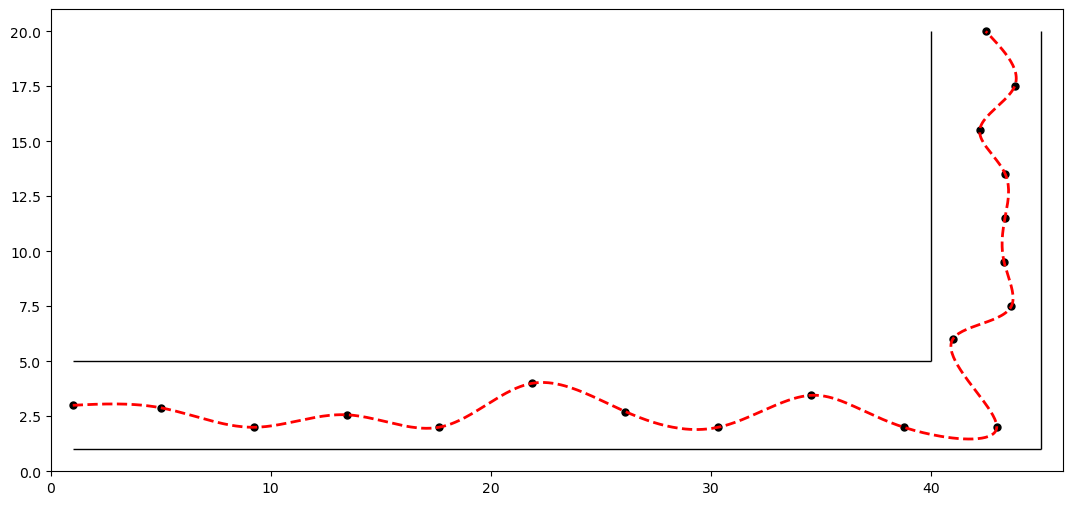

In [4]:
# Plot target points and car trajectory
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(16, 6))

ax.plot(x_point, y_point, 'k.', markersize=10)
ax.plot(cx, cy, 'r--', linewidth=2)

ax.hlines(1, 1, 45, color='k', linestyle='solid', linewidth=1)
ax.hlines(5, 1, 40, color='k', linestyle='solid', linewidth=1)
ax.vlines(45, 1, 20, color='k', linestyle='solid', linewidth=1)
ax.vlines(40, 5, 20, color='k', linestyle='solid', linewidth=1)

ax.set_xlim(0, 46)
ax.set_ylim(0, 21)
ax.set_aspect('equal')


plt.show()

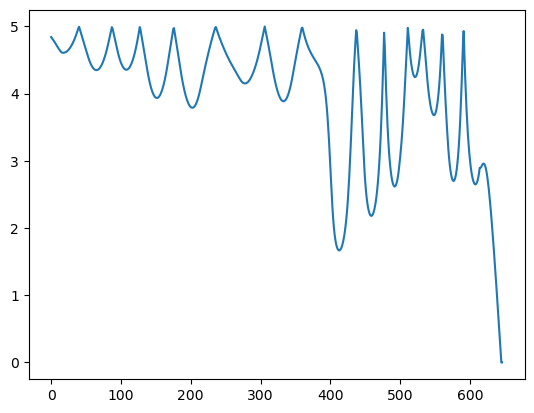

In [154]:
initial_state = Vehicle(x=cx[0], y=cy[0], yaw=cyaw[0], v=2.0)

speed_reduction = np.diff(cyaw)
speed_reduction = np.concatenate([speed_reduction[int(len(speed_reduction)*0.025):],
                                  np.linspace(speed_reduction[-1], 0, int(len(speed_reduction)*0.025))])
speed_reduction = np.convolve(speed_reduction, np.ones(30)/30, mode='same')
speed_reduction = ((1.5*np.max(np.abs(speed_reduction)) - np.abs(speed_reduction)) / (1.5*np.max(np.abs(speed_reduction))))
speed_reduction = np.clip(speed_reduction, 0, 1)
speed_reduction *= np.concatenate([np.ones(int(len(speed_reduction)*0.95)+1), np.linspace(1, 0, int(len(speed_reduction)*0.05))])

dl = 1.0
simulation = Simulation(initial_state, goal_speed=0.5, target_speed=5)
sp = np.array(simulation.calc_speed_profile(cx, cy, cyaw))

sp[:-1] *= speed_reduction

# Smooth tmp
plt.plot(sp)

In [155]:
states_hist, controls_hist = simulation.simulate(cx, cy, cyaw, ck, dl, sp=sp)

t = states_hist['t']
x, y, v, yaw = states_hist['x'], states_hist['y'], states_hist['v'], states_hist['yaw']
a, d = controls_hist['a'], controls_hist['d']
target_inds, xrefs = controls_hist['target_inds'], controls_hist['xrefs']

MPC: 0it [00:00, ?it/s]

Goal


In [145]:
dx = np.empty_like(x)
dy = np.empty_like(y)

for i in range(len(x)):
    dx[i] = v[i] * math.cos(yaw[i]) * initial_state.dt
    dy[i] = v[i] * math.sin(yaw[i]) * initial_state.dt

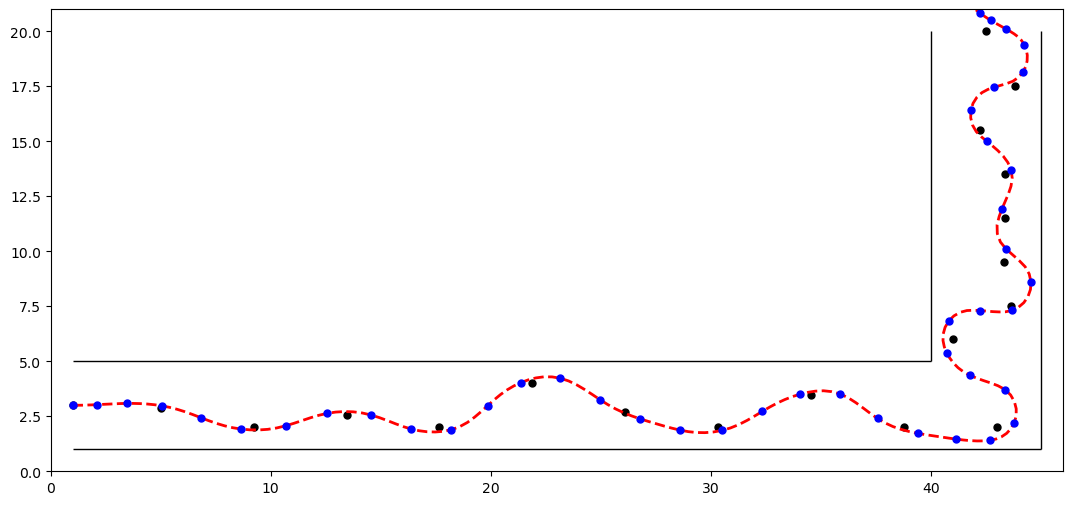

In [146]:
# Plot target points and car trajectory
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(16, 6))

ax.plot(x_point, y_point, 'k.', markersize=10)
ax.plot(x, y, 'r--', linewidth=2)
ax.plot(x[::5], y[::5], 'bo', linewidth=2, markersize=5)

ax.hlines(1, 1, 45, color='k', linestyle='solid', linewidth=1)
ax.hlines(5, 1, 40, color='k', linestyle='solid', linewidth=1)
ax.vlines(45, 1, 20, color='k', linestyle='solid', linewidth=1)
ax.vlines(40, 5, 20, color='k', linestyle='solid', linewidth=1)

ax.set_xlim(0, 46)
ax.set_ylim(0, 21)
ax.set_aspect('equal')


plt.show()

In [76]:
dt = 0.5
q1 = 1
q2 = 1
s1 = 0.5
s2 = 0.5

Q = np.array([[(q1 * dt**3) / 3, 0, (q1 * dt**2) / 2, 0],
              [ 0, (q2 * dt**3) / 3, 0, (q2 * dt**2) / 2],
              [(q1 * dt**2) / 2, 0, q1 * dt, 0],
              [0, (q2 * dt**2) / 2, 0, q2 * dt]])
        
R = np.array([[s1, 0],
              [0, s2]])

In [72]:
t

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
       13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
       14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

def animate(i):
    ax.cla()
    ax.plot(x_point, y_point, "kx", markersize=10)
    ax.plot(x[:i], y[:i], "-b", label="trajectory")
    ax.plot(xrefs[i, 0, :], xrefs[i, 1, :], "xk", label="xref")
    ax.plot(cx[target_inds[i]], cy[target_inds[i]], "xg", label="target")
    plot_car(ax, x[i], y[i], yaw[i], steer=d[i], truckcolor="k")

    ax.set_title("Time[s]:" + str(round(t[i], 2)) + ", speed[km/h]:" + str(round(v[i] * 3.6, 2)))
    ax.hlines(1, 1, 45, color='k', linestyle='solid', linewidth=1)
    ax.hlines(5, 1, 40, color='k', linestyle='solid', linewidth=1)
    ax.vlines(45, 1, 20, color='k', linestyle='solid', linewidth=1)
    ax.vlines(40, 5, 20, color='k', linestyle='solid', linewidth=1)
    
    ax.grid(True)
    ax.set_xlim(0, 46)
    ax.set_ylim(0, 25)
    ax.set_aspect('equal')

ani = animation.FuncAnimation(fig, animate, frames=len(x), repeat=False)

# Save animation with progress bar
with tqdm(total=len(t)) as pbar:
    ani.save('animation.gif', writer='Pillow', fps=25, progress_callback=lambda i, n: pbar.update())

plt.close()

  0%|          | 0/411 [00:00<?, ?it/s]

MovieWriter Pillow unavailable; using Pillow instead.
